📄 Dataset Description
This dataset is designed for the task of Named Entity Recognition (NER), a fundamental subtask of Natural Language Processing (NLP) that involves identifying and categorizing entities in text into predefined classes. NER is widely used in NLP applications such as information retrieval, question answering, and text summarization, where extracting structured information from unstructured text is essential.

The dataset consists of approximately 1,696 sentences, each containing a variable number of words. Each token in a sentence is annotated with its corresponding entity label. The format of the data is as follows:

Each line contains two columns, separated by a space:
The first column is the word (token).
The second column is its entity label.
The possible entity labels include:

I-LOC – Location entity
I-PER – Person entity
I-ORG – Organization entity
I-MISC – Miscellaneous entity
O – Outside (not an entity)
Sentences are separated by a blank line (\n), making it easy to identify sentence boundaries during preprocessing.

The goal of this assignment is to preprocess this data and build neural network models capable of learning and performing NER classification based on this structure.

In [4]:
from warnings import filterwarnings

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

import torch
from sympy.utilities.exceptions import ignore_warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm
import warnings
from torch.utils.data import TensorDataset

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [157]:
warnings.filterwarnings("ignore")

In [119]:
# Fixing random seed for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

## Exploratory analysis

In [2]:
DATA_PATH = "assignment3-ner_dataset.txt"

In [3]:
#Function to load dataset
def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.read().strip().split("\n")

    sentences = []
    tags = []
    current_sent = []
    current_tags = []

    for line in lines:
        if line == "":
            if current_sent:
                sentences.append(current_sent)
                tags.append(current_tags)
                current_sent = []
                current_tags = []
        else:
            word, tag = line.split()
            current_sent.append(word)
            current_tags.append(tag)

    if current_sent:  # Add the last sentence if not already added
        sentences.append(current_sent)
        tags.append(current_tags)

    return sentences, tags

sentences, tags = load_data(DATA_PATH)
print(f"Loaded {len(sentences)} sentences.")

# Build vocabularies
word2idx = {"<PAD>": 0, "<UNK>": 1}
tag2idx = {"<PAD>": 0}

for sent in sentences:
    for word in sent:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

for tag_seq in tags:
    for tag in tag_seq:
        if tag not in tag2idx:
            tag2idx[tag] = len(tag2idx)

idx2tag = {v: k for k, v in tag2idx.items()}


Loaded 1696 sentences.


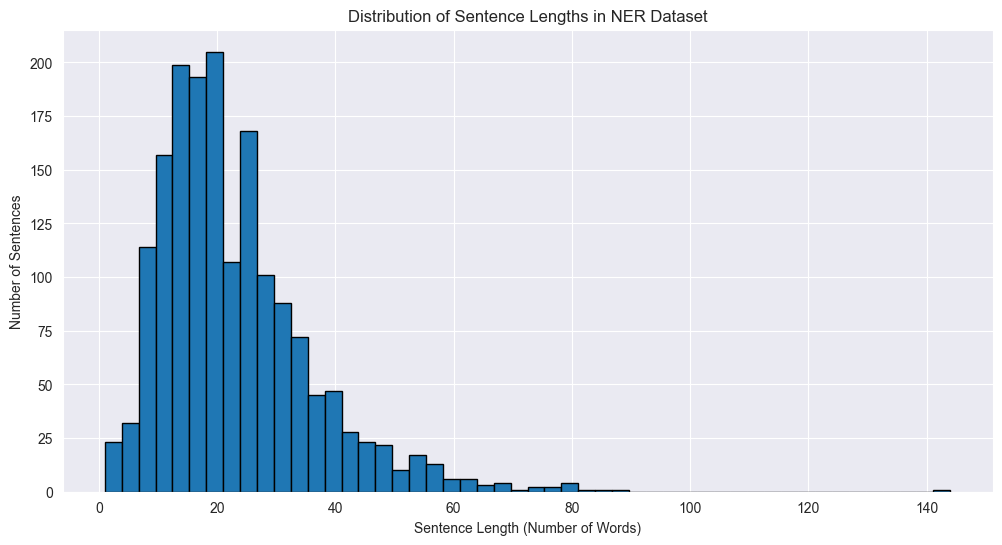

Mean Sentence Length: 23.00
Standard Deviation: 13.10
Recommended max_len (mean + 3*std): 62


In [122]:

sentence_lengths = [len(sentence) for sentence in sentences]

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Sentence Lengths in NER Dataset")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Number of Sentences")
plt.grid(True)
plt.show()

mean_length = np.mean(sentence_lengths)
std_length = np.std(sentence_lengths)
recommended_max_len = int(mean_length + 3 * std_length)

print(f"Mean Sentence Length: {mean_length:.2f}")
print(f"Standard Deviation: {std_length:.2f}")
print(f"Recommended max_len (mean + 3*std): {recommended_max_len}")


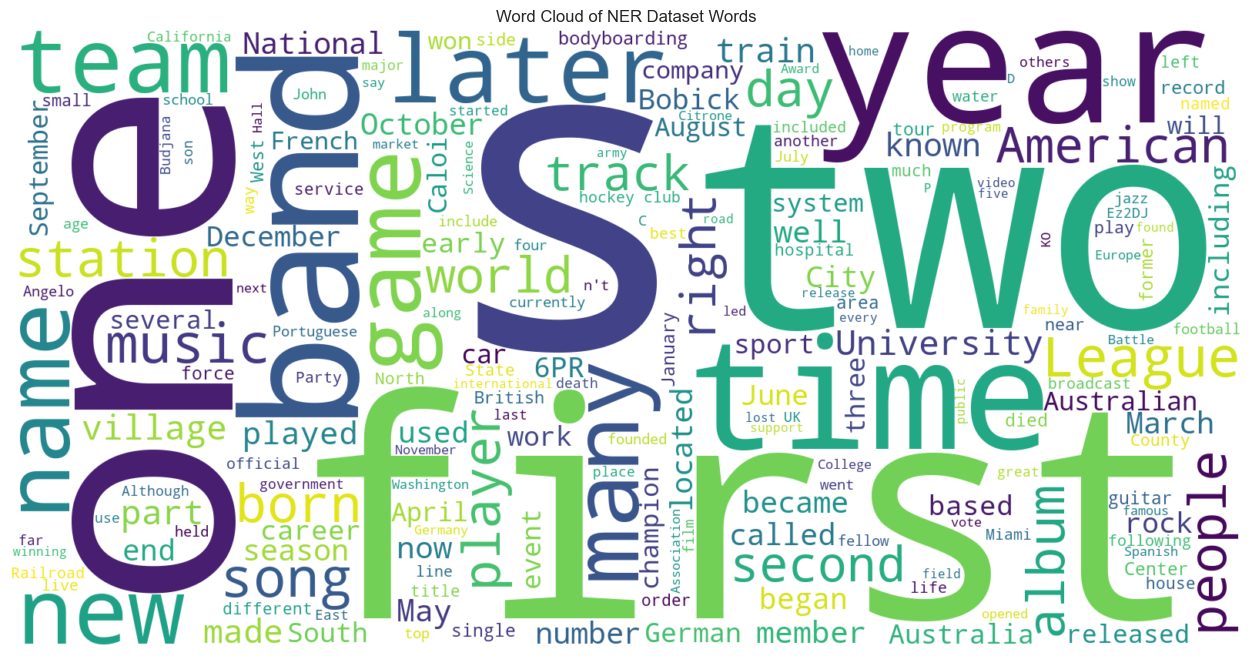

In [123]:
#Word cloud visualization

all_words = []

for sentence in sentences:
    all_words.extend(sentence)

# Joining all words into a single string
text = ' '.join(all_words)

# Creating and configuring the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(text)

# Displaying the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of NER Dataset Words")
plt.show()


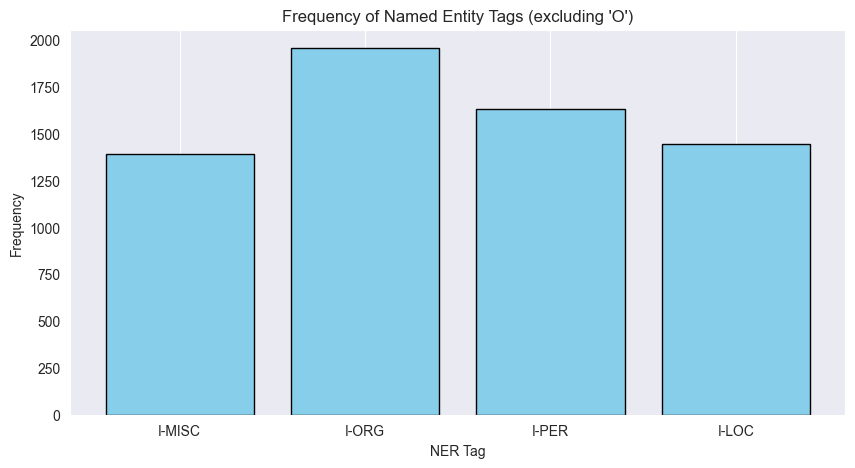

In [124]:
# Loading tags from the dataset
def load_tags(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.read().strip().split("\n")

    tags = []
    for line in lines:
        if line != "":
            _, tag = line.split()
            if tag != "O":  # Excluding 'O' tags as their frequency is high
                tags.append(tag)
    return tags

# Loading and counting tag frequencies
file_path = "assignment3-ner_dataset.txt"
tags = load_tags(file_path)
tag_counts = Counter(tags)

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue', edgecolor='black')
plt.title("Frequency of Named Entity Tags (excluding 'O')")
plt.xlabel("NER Tag")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()


Setting max_len as 62 as per our analysis

In [125]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word2idx, tag2idx, max_len=62):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]
        x = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in words]
        y = [self.tag2idx[tag] for tag in tags]

        # Padding
        x = x[:self.max_len] + [self.word2idx["<PAD>"]] * (self.max_len - len(x))
        y = y[:self.max_len] + [self.tag2idx["<PAD>"]] * (self.max_len - len(y))

        return torch.tensor(x), torch.tensor(y)

# K-Fold Cross-Validation setup
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

folds = list(kf.split(sentences))

print("Prepared 5-fold cross-validation splits.")

#Creating a dataset and dataloader for fold 0
train_idx, test_val_idx = folds[0]
test_size = len(test_val_idx) // 2
val_idx = test_val_idx[:test_size]
test_idx = test_val_idx[test_size:]

train_dataset = NERDataset([sentences[i] for i in train_idx], [tags[i] for i in train_idx], word2idx, tag2idx)
val_dataset = NERDataset([sentences[i] for i in val_idx], [tags[i] for i in val_idx], word2idx, tag2idx)
test_dataset = NERDataset([sentences[i] for i in test_idx], [tags[i] for i in test_idx], word2idx, tag2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("DataLoaders ready for fold 0.")

Prepared 5-fold cross-validation splits.
DataLoaders ready for fold 0.


## Training neural networks

In [172]:
DATA_PATH = "assignment3-ner_dataset.txt"
BATCH_SIZE = 32
MAX_LEN = 128
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_EPOCHS = 10
LEARNING_RATE = 5e-5
DROPOUT = 0.1
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
WARMUP_STEPS = 1000

torch.manual_seed(42)
np.random.seed(42)

In [189]:
def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.read().strip().split("\n")
    sentences, tags, s, t = [], [], [], []
    for line in lines:
        if line == "":
            if s:
                sentences.append(s)
                tags.append(t)
                s, t = [], []
        else:
            word, tag = line.split()[0], line.split()[-1]
            s.append(word)
            t.append(tag)
    if s: sentences.append(s); tags.append(t)
    return sentences, tags

def build_vocab(sentences, tags):
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    tag2idx = {"<PAD>": 0}
    for sent in sentences:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = len(word2idx)
    for tag_seq in tags:
        for tag in tag_seq:
            if tag not in tag2idx:
                tag2idx[tag] = len(tag2idx)
    return word2idx, tag2idx, {v: k for k, v in tag2idx.items()}

class NERDataset(Dataset):
    def __init__(self, sentences, tags, word2idx, tag2idx):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in self.sentences[idx]]
        tags = [self.tag2idx[t] for t in self.tags[idx]]
        mask = [1] * len(words)
        return torch.LongTensor(words), torch.LongTensor(tags), torch.LongTensor(mask), len(words)

def collate_fn(batch):
    words, tags, masks, lengths = zip(*batch)
    return (
        pad_sequence(words, batch_first=True, padding_value=0),
        pad_sequence(tags, batch_first=True, padding_value=0),
        pad_sequence(masks, batch_first=True, padding_value=0),
        torch.LongTensor(lengths)
    )

def evaluate_model(model, dataloader, tag2idx, idx2tag, is_transformer=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()
    preds, labels = [], []

    with torch.no_grad():
        for words, tags, masks, lengths in dataloader:
            words, tags, masks = words.to(device), tags.to(device), masks.to(device)
            lengths = lengths.to(device)

            if is_transformer:
                out = model(words, src_key_padding_mask=masks)
            else:
                out = model(words, lengths)

            _, pred = out.max(dim=2)

            for i in range(len(lengths)):
                length = lengths[i].item()
                preds.extend(pred[i, :length].cpu().numpy())
                labels.extend(tags[i, :length].cpu().numpy())

    # Converting indices to tag strings, skipping PAD
    pred_tags = [idx2tag[p] for p, t in zip(preds, labels) if idx2tag[t] != "<PAD>"]
    true_tags = [idx2tag[t] for t in labels if idx2tag[t] != "<PAD>"]

    assert len(pred_tags) == len(true_tags), f"Length mismatch: {len(pred_tags)} vs {len(true_tags)}"
    return classification_report(true_tags, pred_tags)


def plot_training(history, prefix=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history["train_f1"], label="Train F1")
    plt.plot(history["val_f1"], label="Val F1")
    plt.title("F1 Score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_training.png")
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, tag2idx=None, is_transformer=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}
    best_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, preds, labels = 0, [], []
        for words, tags, masks, lengths in train_loader:
            words, tags, masks = words.to(device), tags.to(device), masks.to(device)
            optimizer.zero_grad()
            out = model(words, src_key_padding_mask=masks) if is_transformer else model(words, lengths)
            active_loss = (tags != 0)
            logits = out.view(-1, out.shape[-1])[active_loss.view(-1)]
            labels_flat = tags.view(-1)[active_loss.view(-1)]
            loss = criterion(logits, labels_flat)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if scheduler: scheduler.step()

            train_loss += loss.item()
            _, pred = out.max(dim=2)
            for i, l in enumerate(lengths):
                preds.extend(pred[i, :l].cpu().numpy())
                labels.extend(tags[i, :l].cpu().numpy())

        train_f1 = f1_score(labels, preds, average='weighted')
        val_report = evaluate_model(model, val_loader, tag2idx, {v: k for k, v in tag2idx.items()}, is_transformer)
        val_f1 = float(val_report.split()[-2])
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_f1)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        print(f"Epoch {epoch+1}: Train F1={train_f1:.4f}, Val F1={val_f1:.4f}")
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_model_{'transformer' if is_transformer else 'lstm'}.pt")
    return history

In [174]:
# === LSTM Model ===
class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, tag_size, emb_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, tag_size)

    def forward(self, x, lengths):
        # Sort by length (descending)
        lengths, perm_idx = lengths.sort(0, descending=True)
        x = x[perm_idx]
    
        x = self.embedding(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.dropout(out)
    
        # Undo sorting to original order
        _, unperm_idx = perm_idx.sort(0)
        out = out[unperm_idx]
    
        return self.fc(out)

In [175]:
# === Transformer Model ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerNER(nn.Module):
    def __init__(self, vocab_size, tag_size, d_model, nhead, num_layers, dim_ff, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_enc = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, tag_size)

    def forward(self, x, src_key_padding_mask):
        x = self.emb(x) * math.sqrt(self.emb.embedding_dim)
        x = self.pos_enc(x)
        x = self.encoder(x, src_key_padding_mask=(src_key_padding_mask == 0))
        return self.fc(x)

class WarmupScheduler:
    def __init__(self, optimizer, d_model, warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self._get_lr()
        for group in self.optimizer.param_groups:
            group['lr'] = lr

    def _get_lr(self):
        step = self.current_step
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

Epoch 1: Train F1=0.5690, Val F1=0.7400
Epoch 2: Train F1=0.7628, Val F1=0.7400
Epoch 3: Train F1=0.7629, Val F1=0.7400
Epoch 4: Train F1=0.7655, Val F1=0.7400
Epoch 5: Train F1=0.7852, Val F1=0.7600
Epoch 6: Train F1=0.8198, Val F1=0.7700
Epoch 7: Train F1=0.8546, Val F1=0.7900
Epoch 8: Train F1=0.8836, Val F1=0.8000
Epoch 9: Train F1=0.9030, Val F1=0.7900
Epoch 10: Train F1=0.9152, Val F1=0.8100
Epoch 11: Train F1=0.9234, Val F1=0.8200
Epoch 12: Train F1=0.9269, Val F1=0.7800
Epoch 13: Train F1=0.9275, Val F1=0.8000
Epoch 14: Train F1=0.9329, Val F1=0.8100
Epoch 15: Train F1=0.9377, Val F1=0.8000
Epoch 16: Train F1=0.9452, Val F1=0.8200
Epoch 17: Train F1=0.9428, Val F1=0.8200
Epoch 18: Train F1=0.9459, Val F1=0.8400
Epoch 19: Train F1=0.9500, Val F1=0.8200
Epoch 20: Train F1=0.9611, Val F1=0.8300
Epoch 21: Train F1=0.9586, Val F1=0.8400
Epoch 22: Train F1=0.9616, Val F1=0.8300
Epoch 23: Train F1=0.9572, Val F1=0.8300
Epoch 24: Train F1=0.9631, Val F1=0.8400
Epoch 25: Train F1=0.9649

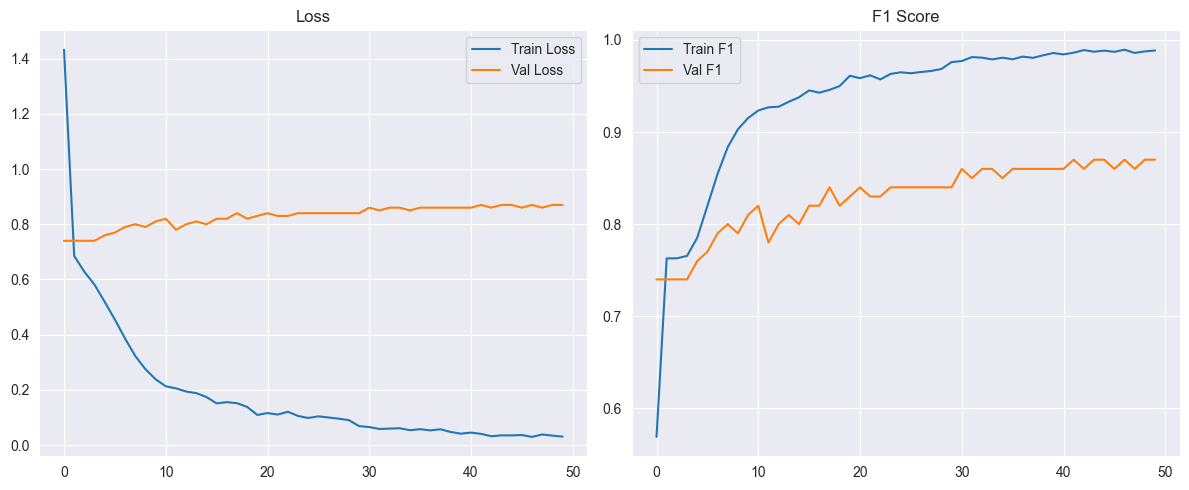

In [176]:
# === Main Execution ===
def main(model_type="lstm"):
    sentences, tags = load_data(DATA_PATH)
    word2idx, tag2idx, idx2tag = build_vocab(sentences, tags)
    train_sent, temp_sent, train_tag, temp_tag = train_test_split(sentences, tags, test_size=0.3)
    val_sent, test_sent, val_tag, test_tag = train_test_split(temp_sent, temp_tag, test_size=0.5)

    train_loader = DataLoader(NERDataset(train_sent, train_tag, word2idx, tag2idx), batch_size=BATCH_SIZE, collate_fn=collate_fn)
    val_loader = DataLoader(NERDataset(val_sent, val_tag, word2idx, tag2idx), batch_size=BATCH_SIZE, collate_fn=collate_fn)

    if model_type == "lstm":
        model = BiLSTMNER(len(word2idx), len(tag2idx), emb_dim=100, hidden_dim=HIDDEN_DIM)
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        history = train_model(model, train_loader, val_loader, criterion, optimizer, tag2idx=tag2idx)
        plot_training(history, prefix="lstm")
    else:
        model = TransformerNER(len(word2idx), len(tag2idx), EMBEDDING_DIM, NUM_HEADS, NUM_ENCODER_LAYERS, HIDDEN_DIM, DROPOUT)
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)
        scheduler = WarmupScheduler(optimizer, d_model=EMBEDDING_DIM, warmup_steps=WARMUP_STEPS)
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, tag2idx=tag2idx, is_transformer=True)
        plot_training(history, prefix="transformer")

if __name__ == "__main__":
    main(model_type="transformer")  

Epoch 1: Train F1=0.2042, Val F1=0.4500
Epoch 2: Train F1=0.5477, Val F1=0.6700
Epoch 3: Train F1=0.6997, Val F1=0.7500
Epoch 4: Train F1=0.7531, Val F1=0.7600
Epoch 5: Train F1=0.7643, Val F1=0.7600
Epoch 6: Train F1=0.7651, Val F1=0.7600
Epoch 7: Train F1=0.7653, Val F1=0.7600
Epoch 8: Train F1=0.7653, Val F1=0.7600
Epoch 9: Train F1=0.7654, Val F1=0.7600
Epoch 10: Train F1=0.7654, Val F1=0.7600
Epoch 11: Train F1=0.7653, Val F1=0.7600
Epoch 12: Train F1=0.7653, Val F1=0.7600
Epoch 13: Train F1=0.7653, Val F1=0.7600
Epoch 14: Train F1=0.7652, Val F1=0.7600
Epoch 15: Train F1=0.7654, Val F1=0.7600
Epoch 16: Train F1=0.7652, Val F1=0.7600
Epoch 17: Train F1=0.7653, Val F1=0.7600
Epoch 18: Train F1=0.7653, Val F1=0.7600
Epoch 19: Train F1=0.7656, Val F1=0.7600
Epoch 20: Train F1=0.7655, Val F1=0.7600
Epoch 21: Train F1=0.7653, Val F1=0.7600
Epoch 22: Train F1=0.7655, Val F1=0.7600
Epoch 23: Train F1=0.7655, Val F1=0.7600
Epoch 24: Train F1=0.7655, Val F1=0.7600
Epoch 25: Train F1=0.7657

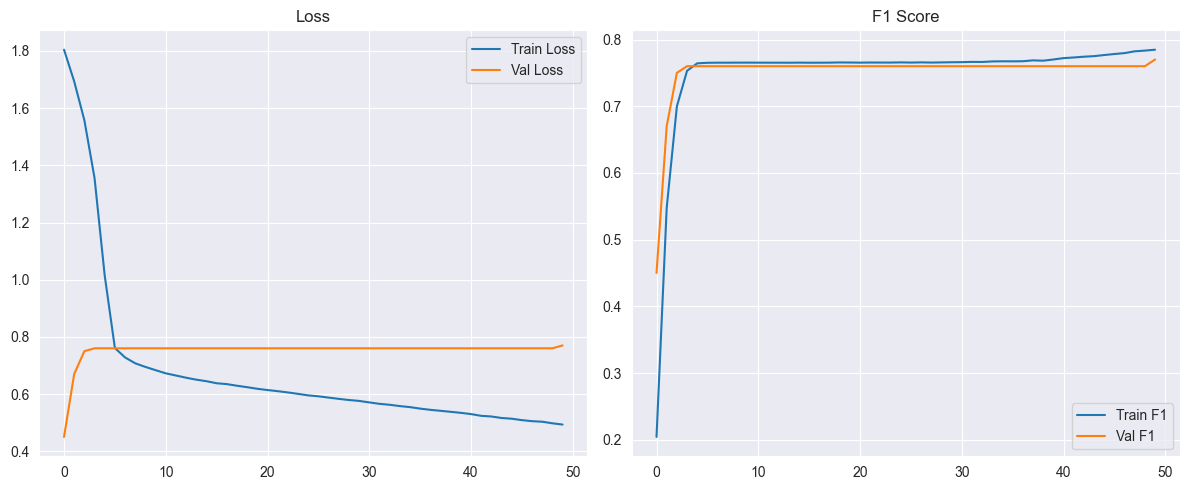

In [177]:
if __name__ == "__main__":
    main(model_type="lstm")

## Model evaluation


In [198]:
# Loading and preparing data
sentences, tags = load_data(DATA_PATH)
word2idx, tag2idx, idx2tag = build_vocab(sentences, tags)

# Recreating test split
_, temp_sent, _, temp_tag = train_test_split(sentences, tags, test_size=0.3, random_state=42)
val_sent, test_sent, val_tag, test_tag = train_test_split(temp_sent, temp_tag, test_size=0.5, random_state=42)

test_dataset = NERDataset(test_sent, test_tag, word2idx, tag2idx)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Loading Transformer Model
model = TransformerNER(
    vocab_size=len(word2idx),
    tag_size=len(tag2idx),
    d_model=EMBEDDING_DIM,
    nhead=NUM_HEADS,
    num_layers=NUM_ENCODER_LAYERS,
    dim_ff=HIDDEN_DIM, 
    dropout=DROPOUT
)
model.load_state_dict(torch.load("best_model_transformer.pt"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluating
all_preds, all_labels = [], []
with torch.no_grad():
    for words, tags, masks, lengths in test_loader:
        words, tags, masks = words.to(device), tags.to(device), masks.to(device)
        outputs = model(words, src_key_padding_mask=masks)
        _, predicted = outputs.max(dim=2)
        for i in range(len(lengths)):
            l = lengths[i].item()
            all_preds.extend(predicted[i, :l].cpu().numpy())
            all_labels.extend(tags[i, :l].cpu().numpy())

# Converting to tag names
pred_tags = [idx2tag[p] for p, t in zip(all_preds, all_labels) if idx2tag[t] != "<PAD>"]
true_tags = [idx2tag[t] for t in all_labels if idx2tag[t] != "<PAD>"]

assert len(pred_tags) == len(true_tags), "Prediction and label lengths do not match."

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    print("=== Transformer Model Test Set Evaluation ===")
    print(classification_report(true_tags, pred_tags, zero_division=0))
    print("Macro F1:", f1_score(true_tags, pred_tags, average='macro', zero_division=0))
    print("Micro F1:", f1_score(true_tags, pred_tags, average='micro', zero_division=0))
    print("Weighted F1:", f1_score(true_tags, pred_tags, average='weighted', zero_division=0))
    print("Precision:", precision_score(true_tags, pred_tags, average='weighted', zero_division=0))
    print("Recall:", recall_score(true_tags, pred_tags, average='weighted', zero_division=0))

=== Transformer Model Test Set Evaluation ===
              precision    recall  f1-score   support

       I-LOC       0.85      0.91      0.88       229
      I-MISC       0.89      0.78      0.83       232
       I-ORG       0.83      0.72      0.77       279
       I-PER       0.93      0.78      0.85       269
           O       0.97      0.99      0.98      5026

    accuracy                           0.96      6035
   macro avg       0.90      0.84      0.86      6035
weighted avg       0.96      0.96      0.96      6035

Macro F1: 0.8626362135345419
Micro F1: 0.9569179784589892
Weighted F1: 0.9555335957148585
Precision: 0.9556620139781176
Recall: 0.9569179784589892
